**Downloading the data**



In [2]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  1267k      0  0:01:04  0:01:04 --:--:-- 2324k


Preparing the data

In [3]:
import os, pathlib, shutil, random
from tensorflow import keras
batchSize = 32
base_dir= pathlib.Path("/content/aclImdb")
val_dir = base_dir/ "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True )

    files = os.listdir(train_dir / category)
    random.Random(1496).shuffle(files)
    num_val_samples = 10000
    validation_files = files[-num_val_samples:]
    for fname in validation_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batchSize
).take(100)  # Restrict training samples to 100

val_ds = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=batchSize
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batchSize
)
te_only_train_ds = train_ds.map(lambda x, y: x)


Found 5000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Setting up datasets for numeric sequences

**A sequence model built on one-hot encoded vector sequences**

In [4]:
from tensorflow.keras import layers

MAX_SEQUENCE_LENGTH = 150   # Cutoff reviews after 150 words
MAX_VOCAB_SIZE = 10000      # Consider only the top 10,000 words

# Define TextVectorization layer
t_vectorization = layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

# Extract texts only from train_ds for vectorization adaptation
train_texts_only = train_ds.map(lambda x, y: x)
t_vectorization.adapt(train_texts_only)

# Vectorize the train, validation, and test datasets
int_train_dataset = train_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4
)
int_val_dataset = val_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4
)
int_test_ds = test_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4
)


In [5]:
import tensorflow as tf  # Model with embedding layer

input_layer = keras.Input(shape=(None,), dtype="int64")
embedding_output = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(input_layer)
x = layers.Bidirectional(layers.LSTM(32))(embedding_output)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(input_layer, output_layer)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │      2,560,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 64)             │         73,984 │ embedding[0][0],       │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │             65 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Developing a fundamental sequencing concept initially

In [25]:
checkpoint_callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
# Ensure this is run before plotting
history = model.fit(int_train_dataset, validation_data=int_val_dataset, epochs=15, callbacks=checkpoint_callbacks)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.8207 - loss: 0.3957 - val_accuracy: 0.7929 - val_loss: 0.4438
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.8239 - loss: 0.3852 - val_accuracy: 0.7863 - val_loss: 0.4528
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.8310 - loss: 0.3778 - val_accuracy: 0.7948 - val_loss: 0.4428
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.8428 - loss: 0.3634 - val_accuracy: 0.7966 - val_loss: 0.4463
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.8536 - loss: 0.3350 - val_accuracy: 0.7951 - val_loss: 0.4752
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.8538 - loss: 0.3361 - val_accuracy: 0.7954 - val_loss: 0.4472
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.8619 - loss: 0.3069 - val_accuracy: 0.7912 - val_loss: 0.5059
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.8656 - loss: 0.3164 -

In [28]:
model = keras.models.load_model('one_hot_bidir_lstm.keras')
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7893 - loss: 0.4428
Test acc: 0.792


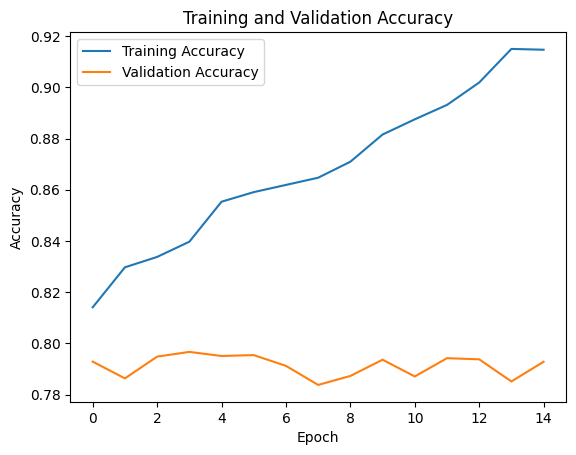

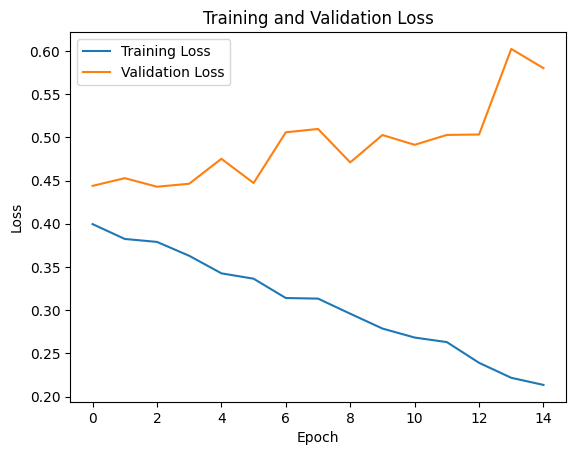

In [26]:

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Using the Embedded level to acquire embedded words

Putting an Anchoring level into Action


In [8]:
em_layer = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)

Anchor layer system which was developed form start

In [9]:
in1 = keras.Input(shape=(None,), dtype="int64")
em1 = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)(in1)
x = layers.Bidirectional(layers.LSTM(32))(em1)
x = layers.Dropout(0.5)(x)
output_layer1 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in1, output_layer1)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 256)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
checkpoint_callbacks1 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",  # Change to .keras
                                    save_best_only=True)
]

history1 = model.fit(int_train_dataset, validation_data=int_val_dataset, epochs=15, callbacks=checkpoint_callbacks1)

# Load the best model saved by the callback
model = keras.models.load_model("embeddings_bidir_gru.keras")

# Evaluate the model on the test dataset
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.5170 - loss: 0.6925 - val_accuracy: 0.5774 - val_loss: 0.6799
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.6377 - loss: 0.6455 - val_accuracy: 0.6757 - val_loss: 0.6058
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.7467 - loss: 0.5248 - val_accuracy: 0.7400 - val_loss: 0.5272
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.8285 - loss: 0.4140 - val_accuracy: 0.6662 - val_loss: 0.7260
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.8713 - loss: 0.3388 - val_accuracy: 0.7922 - val_loss: 0.4988
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8978 - loss: 0.2705 - val_accuracy: 0.7377 - val_loss: 0.6325
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9160 - loss: 0.2406 - val_accuracy: 0.7704 - val_loss: 0.6362
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9487 - loss: 0.1686 - val_

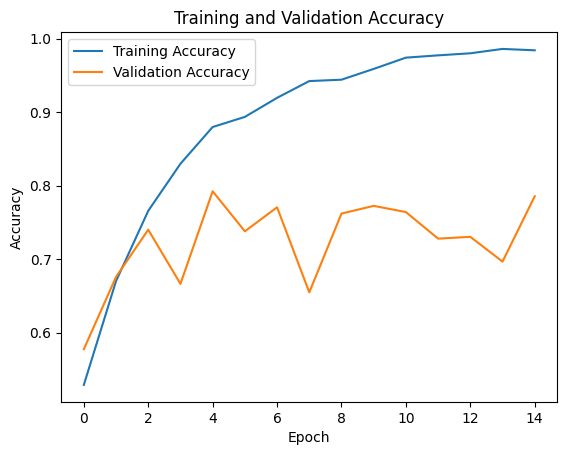

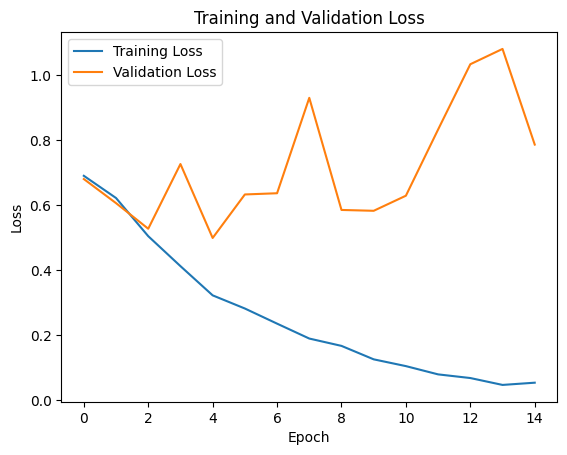

In [11]:
# Plot training and validation accuracy
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Recognizing blurring and filling

Applying filtering to an Anchoring level


In [12]:
in2 = keras.Input(shape=(None,), dtype="int64")
em2 = layers.Embedding(
    input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(in2)
x = layers.Bidirectional(layers.LSTM(32))(em2)
x = layers.Dropout(0.5)(x)
output_layer2 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in2, output_layer2)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 256)      │      2,560,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, None)           │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 64)             │         73,984 │ embedding_3[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
checkpoint_callbacks2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
history2=model.fit(int_train_dataset, validation_data= int_val_dataset, epochs=15, callbacks=checkpoint_callbacks2)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.5342 - loss: 0.6880 - val_accuracy: 0.6831 - val_loss: 0.6142
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.6838 - loss: 0.5842 - val_accuracy: 0.7559 - val_loss: 0.5076
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.8269 - loss: 0.4103 - val_accuracy: 0.7479 - val_loss: 0.5493
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8797 - loss: 0.3008 - val_accuracy: 0.7096 - val_loss: 0.6747
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9069 - loss: 0.2361 - val_accuracy: 0.7844 - val_loss: 0.4925
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9397 - loss: 0.1520 - val_accuracy: 0.7699 - val_loss: 0.5258
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9630 - loss: 0.1136 - val_accuracy: 0.7712 - val_loss: 0.5273
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9760 - loss: 0.0828 - val_a

In [14]:

model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7727 - loss: 0.5104
Test acc: 0.773


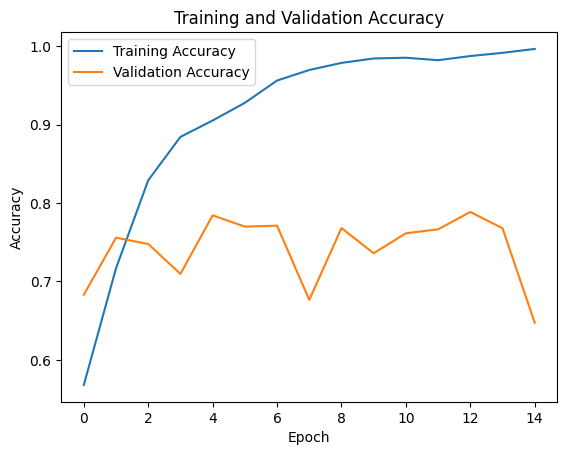

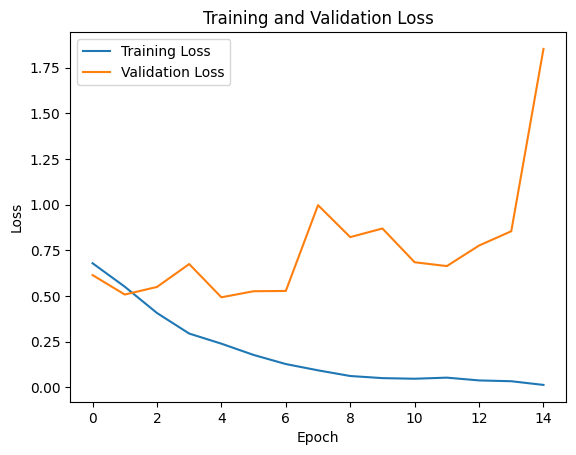

In [15]:
# Plot training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Preconditioned word embeds are used

In [16]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-11-14 05:40:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-14 05:40:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-14 05:40:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Interpreting the word-embeddings package for One

In [17]:
import numpy as np
GLOVE_FILE_PATH = "glove.6B.100d.txt"

glove_embeddings = {}
with open(GLOVE_FILE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs

print(f"Found {len(glove_embeddings)} word vectors.")

Found 400000 word vectors.


Setting up the matrix for the GloVe website embedded words

In [18]:
em_dim = 100

vocab = t_vectorization.get_vocabulary()
word_to_index = dict(zip(vocab, range(len(vocab))))

embedding_matrix = np.zeros((MAX_VOCAB_SIZE, em_dim))
for word, i in word_to_index.items():
    if i < MAX_VOCAB_SIZE:
        em_vector = glove_embeddings.get(word)
    if em_vector is not None:
        embedding_matrix[i] = em_vector

In [19]:
em_layer = layers.Embedding(
    MAX_VOCAB_SIZE,
    em_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

# Architecture with an embedded level which has been trained

In [20]:
in4 = keras.Input(shape=(None,), dtype="int64")
em4 = em_layer(in4)
x = layers.Bidirectional(layers.LSTM(32))(em4)
x = layers.Dropout(0.5)(x)
output_layer4 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in4, output_layer4)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, None, 100)      │      1,000,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, None)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 64)             │         34,048 │ embedding_4[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [21]:
checkpoint_callbacks4 = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]

history4=model.fit(int_train_dataset, validation_data= int_val_dataset, epochs=15, callbacks=checkpoint_callbacks4)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test Accuracy: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.5267 - loss: 0.7047 - val_accuracy: 0.5913 - val_loss: 0.6685
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.5916 - loss: 0.6668 - val_accuracy: 0.6198 - val_loss: 0.6468
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.6656 - loss: 0.6210 - val_accuracy: 0.7186 - val_loss: 0.5580
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.7110 - loss: 0.5641 - val_accuracy: 0.6600 - val_loss: 0.5981
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.7180 - loss: 0.5484 - val_accuracy: 0.7167 - val_loss: 0.5692
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.7513 - loss: 0.5254 - val_accuracy: 0.7233 - val_loss: 0.5387
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.7635 - loss: 0.4998 - val_accuracy: 0.7633 - val_loss: 0.4920
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.7677 - loss: 0.4855 

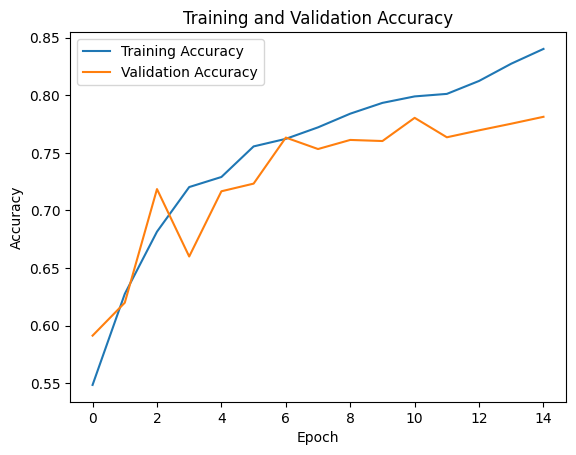

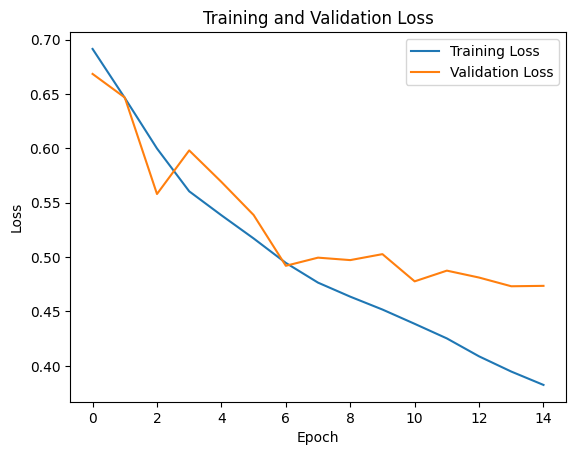

In [22]:
# Plot training and validation accuracy
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5220 - loss: 0.6920 - val_accuracy: 0.5809 - val_loss: 0.6839
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.6501 - loss: 0.6406 - val_accuracy: 0.7339 - val_loss: 0.5508
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.7817 - loss: 0.4998 - val_accuracy: 0.7432 - val_loss: 0.5293
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.8341 - loss: 0.4031 - val_accuracy: 0.7707 - val_loss: 0.4905
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.8901 - loss: 0.3065 - val_accuracy: 0.7829 - val_loss: 0.4918
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.9008 - loss: 0.2669 - val_accuracy: 0.7798 - val_loss: 0.4954
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.9046 - loss: 0.2415 - val_accuracy: 0.7182 - val_loss: 0.5794
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step

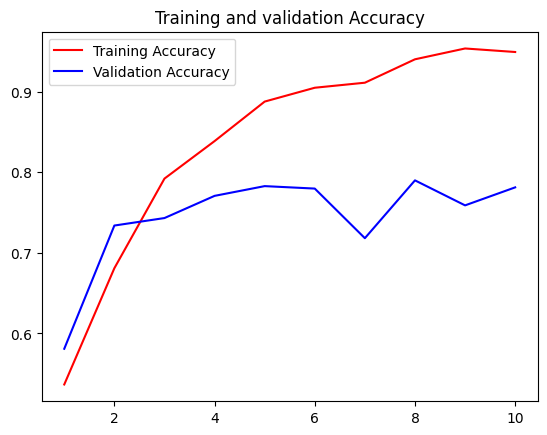

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.5241 - loss: 0.6953 - val_accuracy: 0.6198 - val_loss: 0.6562
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.6208 - loss: 0.6416 - val_accuracy: 0.6952 - val_loss: 0.5905
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.7033 - loss: 0.5800 - val_accuracy: 0.6891 - val_loss: 0.5802
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.7325 - loss: 0.5376 - val_accuracy: 0.7163 - val_loss: 0.5494
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.7586 - loss: 0.5131 - val_accuracy: 0.7556 - val_loss: 0.5058
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.7914 - loss: 0.4703 - val_accuracy: 0.7630 - val_loss: 0.4983
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.7818 - loss: 0.4634 - val_accuracy: 0.7135 - val_loss: 0.5610
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.7979 - loss: 0.4560 

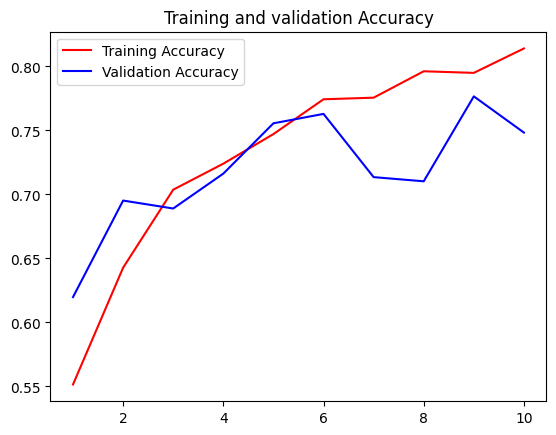

Training samples: 100
Embedding layer test accuracy: 0.763
Pretrained embeddings test accuracy: 0.772
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.5327 - loss: 0.6912 - val_accuracy: 0.6539 - val_loss: 0.6353
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.7110 - loss: 0.5836 - val_accuracy: 0.7845 - val_loss: 0.4722
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8033 - loss: 0.4491 - val_accuracy: 0.8057 - val_loss: 0.4432
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.8650 - loss: 0.3516 - val_accuracy: 0.7272 - val_loss: 0.6725
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8918 - loss: 0.2906 - val_accuracy: 0.7631 - val_loss: 0.7436
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9072 - loss: 0.2699 - val_accuracy: 0.8148 - val_loss: 0.4942
Epoch 7/10
157/157 ━━━━━━━━━━

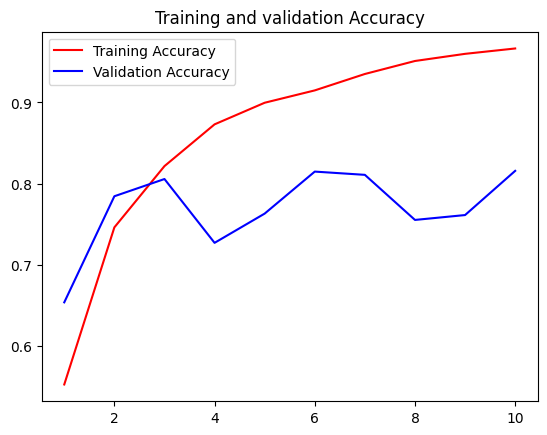

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.5684 - loss: 0.6844 - val_accuracy: 0.6558 - val_loss: 0.6148
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.6751 - loss: 0.6050 - val_accuracy: 0.7253 - val_loss: 0.5495
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.7287 - loss: 0.5462 - val_accuracy: 0.6094 - val_loss: 0.6952
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.7644 - loss: 0.5107 - val_accuracy: 0.7447 - val_loss: 0.5169
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7846 - loss: 0.4705 - val_accuracy: 0.7710 - val_loss: 0.4828
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.7852 - loss: 0.4639 - val_accuracy: 0.7907 - val_loss: 0.4634
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.8004 - loss: 0.4355 - val_accuracy: 0.7888 - val_loss: 0.4533
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.8101 - loss: 0.4326 - v

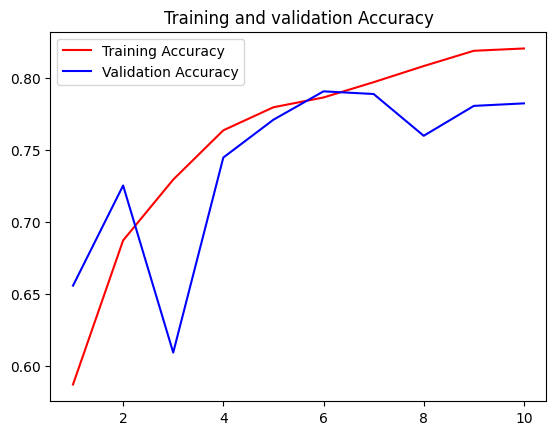

Training samples: 500
Embedding layer test accuracy: 0.803
Pretrained embeddings test accuracy: 0.781
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.5238 - loss: 0.6925 - val_accuracy: 0.5792 - val_loss: 0.6743
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.6612 - loss: 0.6176 - val_accuracy: 0.7408 - val_loss: 0.5344
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.8084 - loss: 0.4393 - val_accuracy: 0.7897 - val_loss: 0.4649
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.8551 - loss: 0.3650 - val_accuracy: 0.8082 - val_loss: 0.4270
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.8968 - loss: 0.2865 - val_accuracy: 0.8055 - val_loss: 0.5831
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.9178 - loss: 0.2334 - val_accuracy: 0.7394 - val_loss: 0.6095
Epoch 7/10
157/157 ━━━━━━━

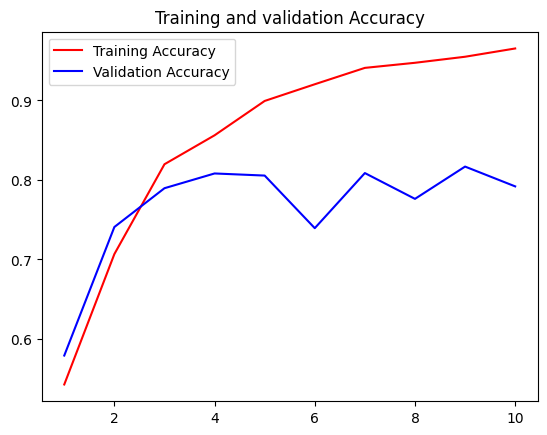

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.5460 - loss: 0.6901 - val_accuracy: 0.6559 - val_loss: 0.6216
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.6684 - loss: 0.6235 - val_accuracy: 0.7247 - val_loss: 0.5565
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.7144 - loss: 0.5685 - val_accuracy: 0.7506 - val_loss: 0.5148
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.7358 - loss: 0.5414 - val_accuracy: 0.5612 - val_loss: 0.9807
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.7428 - loss: 0.5315 - val_accuracy: 0.6675 - val_loss: 0.8171
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.7695 - loss: 0.4898 - val_accuracy: 0.7776 - val_loss: 0.4736
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.7752 - loss: 0.4679 - val_accuracy: 0.7872 - val_loss: 0.4515
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.7868 - loss: 0.4541 - v

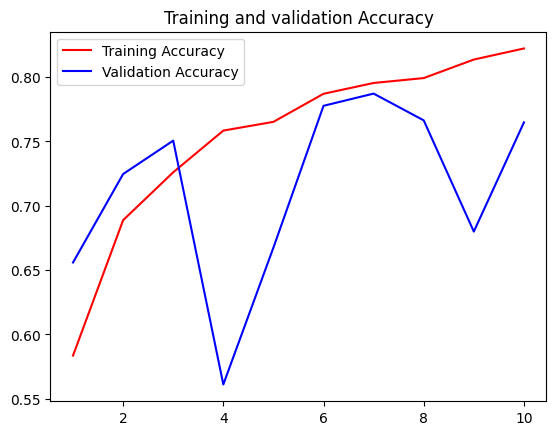

Training samples: 1000
Embedding layer test accuracy: 0.805
Pretrained embeddings test accuracy: 0.784
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.5302 - loss: 0.6903 - val_accuracy: 0.5703 - val_loss: 0.6818
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.7096 - loss: 0.5826 - val_accuracy: 0.6719 - val_loss: 0.6052
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8244 - loss: 0.4355 - val_accuracy: 0.7800 - val_loss: 0.4699
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8606 - loss: 0.3563 - val_accuracy: 0.7854 - val_loss: 0.5870
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.8913 - loss: 0.2934 - val_accuracy: 0.7776 - val_loss: 0.6193
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9143 - loss: 0.2495 - val_accuracy: 0.7806 - val_loss: 0.5154
Epoch 7/10
157/157 ━━━━━━━━━

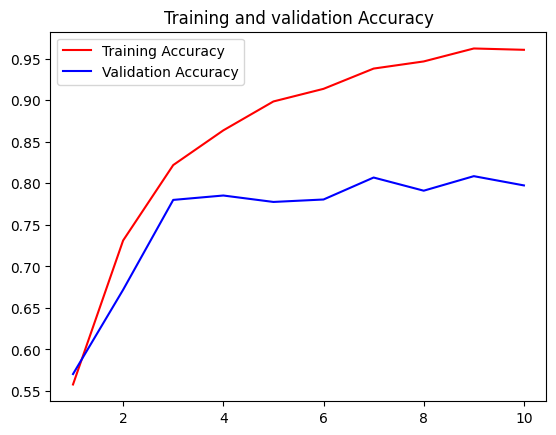

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.5380 - loss: 0.6922 - val_accuracy: 0.5922 - val_loss: 0.6676
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.6677 - loss: 0.6127 - val_accuracy: 0.6792 - val_loss: 0.5985
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7251 - loss: 0.5605 - val_accuracy: 0.7173 - val_loss: 0.5516
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.7365 - loss: 0.5271 - val_accuracy: 0.7553 - val_loss: 0.5026
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.7631 - loss: 0.5027 - val_accuracy: 0.7495 - val_loss: 0.5102
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7765 - loss: 0.4794 - val_accuracy: 0.7704 - val_loss: 0.4806
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.7828 - loss: 0.4715 - val_accuracy: 0.7426 - val_loss: 0.5172
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8027 - loss: 0.4357 - va

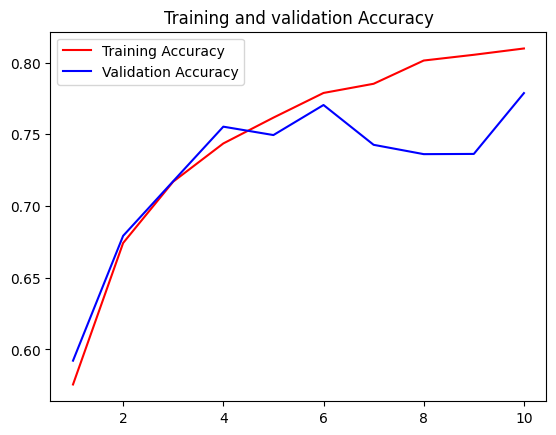

Training samples: 5000
Embedding layer test accuracy: 0.777
Pretrained embeddings test accuracy: 0.775
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5389 - loss: 0.6864 - val_accuracy: 0.7208 - val_loss: 0.5781
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7283 - loss: 0.5646 - val_accuracy: 0.7656 - val_loss: 0.5161
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.8158 - loss: 0.4443 - val_accuracy: 0.7692 - val_loss: 0.4854
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8542 - loss: 0.3576 - val_accuracy: 0.8120 - val_loss: 0.4520
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9005 - loss: 0.2777 - val_accuracy: 0.7459 - val_loss: 0.6048
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9155 - loss: 0.2535 - val_accuracy: 0.8152 - val_loss: 0.4961
Epoch 7/10
157/157 ━━━━━━━━

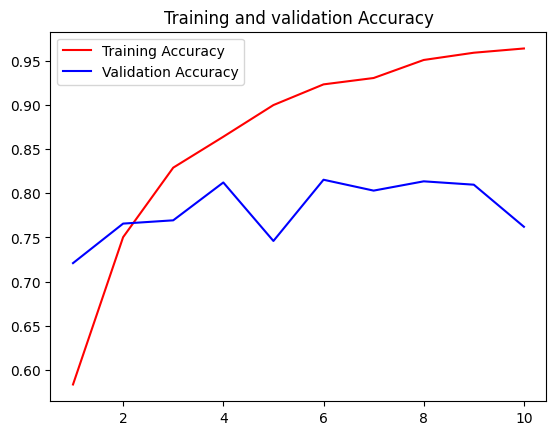

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.5602 - loss: 0.6862 - val_accuracy: 0.6815 - val_loss: 0.5999
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.6665 - loss: 0.6118 - val_accuracy: 0.7211 - val_loss: 0.5620
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.7245 - loss: 0.5503 - val_accuracy: 0.7545 - val_loss: 0.5133
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.7444 - loss: 0.5214 - val_accuracy: 0.6001 - val_loss: 0.7569
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.7593 - loss: 0.4883 - val_accuracy: 0.6888 - val_loss: 0.6063
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.7841 - loss: 0.4665 - val_accuracy: 0.7778 - val_loss: 0.4660
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7886 - loss: 0.4500 - val_accuracy: 0.7176 - val_loss: 0.5554
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.7958 - loss: 0.4368 - va

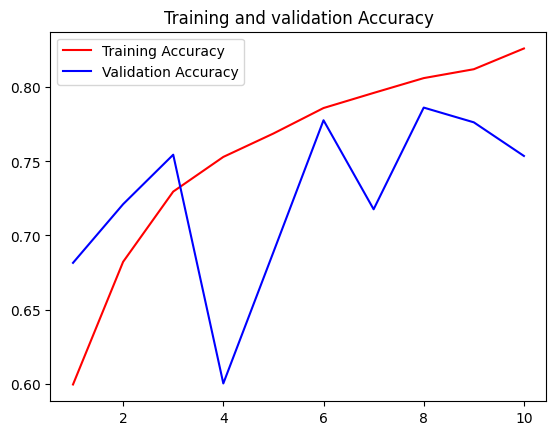

Training samples: 10000
Embedding layer test accuracy: 0.802
Pretrained embeddings test accuracy: 0.783
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.5257 - loss: 0.6905 - val_accuracy: 0.6830 - val_loss: 0.6033
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6963 - loss: 0.5926 - val_accuracy: 0.7244 - val_loss: 0.5608
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.8074 - loss: 0.4529 - val_accuracy: 0.7199 - val_loss: 0.5661
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8468 - loss: 0.3814 - val_accuracy: 0.8047 - val_loss: 0.4436
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.8888 - loss: 0.2953 - val_accuracy: 0.7125 - val_loss: 0.7066
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9047 - loss: 0.2469 - val_accuracy: 0.7433 - val_loss: 0.7322
Epoch 7/10
157/157 ━━━━━━━━

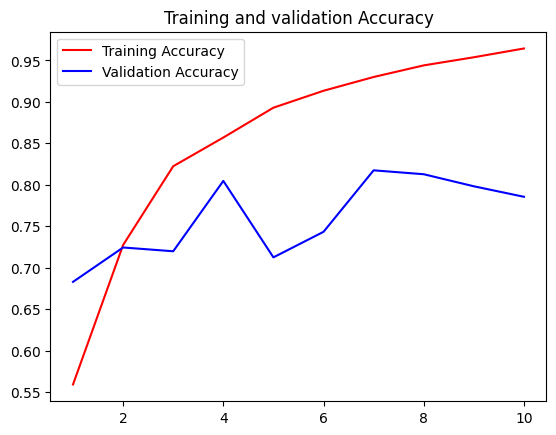

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.5330 - loss: 0.6938 - val_accuracy: 0.6736 - val_loss: 0.6181
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.6755 - loss: 0.6045 - val_accuracy: 0.5253 - val_loss: 0.7588
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.7038 - loss: 0.5759 - val_accuracy: 0.6310 - val_loss: 0.6900
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7490 - loss: 0.5191 - val_accuracy: 0.7523 - val_loss: 0.5052
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7779 - loss: 0.4902 - val_accuracy: 0.7488 - val_loss: 0.5071
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.7802 - loss: 0.4722 - val_accuracy: 0.7615 - val_loss: 0.4904
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.7967 - loss: 0.4539 - val_accuracy: 0.7772 - val_loss: 0.4712
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7962 - loss: 0.4411 - va

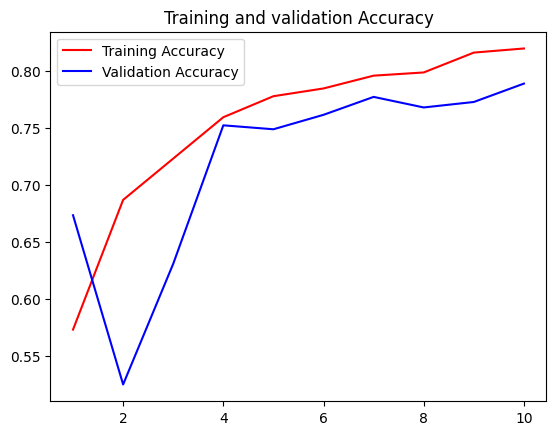

Training samples: 20000
Embedding layer test accuracy: 0.801
Pretrained embeddings test accuracy: 0.789
--------------------------------------------------


In [24]:
train_sample_sizes = [100, 500, 1000, 5000, 10000, 20000]
for train_size in train_sample_sizes:
    train_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=batchSize
    ).take(train_size)

    int_train_ds = train_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_val_ds = val_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_test_ds = test_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the model with the embedding layer
    embedding_layer = layers.Embedding(MAX_VOCAB_SIZE, em_dim)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("embeddings_model.keras")
    embedding_layer_test_acc = model.evaluate(int_test_ds)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Train and evaluate the model with the pretrained word embeddings
    embedding_layer = layers.Embedding(
        MAX_VOCAB_SIZE,
        em_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("pretrained_embeddings_model.keras")
    pretrained_embeddings_test_acc = model.evaluate(int_test_ds)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Compare the performance and store the results
    print(f"Training samples: {train_size}")
    print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
    print("-" * 50)


